# 1st Order GSA

In [ ]:
include("../src/PBCM.jl")

cell_general = cell_default()
cell_design_op = cylindrical_cell_designer(cell_general)
cost = cost_default()

include("../unit_conversion_file.jl")

using DiffEqSensitivity
using PyPlot

per = 10

poro = 0.35
poro_intrvl = [poro*(1 - (per/100)) , poro*(1 + (per/100))]

pos_thic = 150
pos_thic_intrvl = [pos_thic*(1 - (per/100)) , pos_thic*(1 + (per/100))]

neg_thic = 150
neg_thic_intrvl = [neg_thic*(1 - (per/100)) , neg_thic*(1 + (per/100))]

no_cells_yr = 10
no_cells_yr_intrvl = [no_cells_yr*(1 - (per/100)) , no_cells_yr*(1 + (per/100))]

cost_pos_AM = 25
cost_pos_AM_intrvl = [cost_pos_AM*(1 - (per/100)) , cost_pos_AM*(1 + (per/100))]


function gsa_cost(arr)

    cell_general.cathode.por        = arr[1]
    cell_general.cathode.th         = converter([arr[2], mult.pos_th[2], mult.pos_th[3]])
    cell_general.anode.th           = converter([arr[3], mult.neg_th[2], mult.neg_th[3]])
    cost.general_costs.no_units_mfg = converter([arr[4], mult.units_mfg[2], mult.units_mfg[3]])
    cost.cell_costs.cathode.AM[1]   = arr[5]

    dollars_kWh = cost_calc(cell_general, cost, system="Cell", cost_verbosity=0)[1]

    return dollars_kWh
end

# gsa_cost([0.25, 150.0, 130.0, 25.0, 19.0])

gsa_result = gsa(gsa_cost, Sobol(), [poro_intrvl, pos_thic_intrvl, neg_thic_intrvl, no_cells_yr_intrvl, cost_pos_AM_intrvl], N = 10000)


print("\n")
S1 = gsa_result.S1
print(S1)

clf()
x = ["Pos Porosity", "Pos Th", "Neg Th", "Cells MFG", "Pos AM Cost"]
bar(x, S1, color="#0f87bf", align="center", alpha=0.8)
ylabel("Sobol Indices")

title(string("GSA: 1st Order : ", per, " %"))
figure(2)


# 2nd Order GSA

In [ ]:
include("../src/PBCM.jl")

cell_general = cell_default()
cell_design_op = cylindrical_cell_designer(cell_general)
cost = cost_default()

include("../unit_conversion_file.jl")


using DiffEqSensitivity
using PyPlot

per = 30

no_cells_yr = 10
no_cells_yr_intrvl = [no_cells_yr*(1 - (per/100)) , no_cells_yr*(1 + (per/100))]

cost_pos_AM = 18.0
cost_pos_AM_intrvl = [cost_pos_AM*(1 - (per/100)) , cost_pos_AM*(1 + (per/100))]

cost_neg_AM = 12.5
cost_neg_AM_intrvl = [cost_neg_AM*(1 - (per/100)) , cost_neg_AM*(1 + (per/100))]

cost_sep = 1.1
cost_sep_intrvl    = [cost_sep  * (1 - (per/100)) , cost_sep * (1  + (per/100))]

function gsa_cost(arr)

    cost.general_costs.no_units_mfg   = converter([arr[1], mult.units_mfg[2], mult.units_mfg[3]])
    cost.cell_costs.cathode.AM[1]     = arr[2]
    cost.cell_costs.anode.AM[1]       = arr[3]
    cost.cell_costs.seperator_cost[1] = arr[4]

    dollars_kWh = cost_calc(cell_general, cost, system="Cell", cost_verbosity=0)[1]

    return dollars_kWh
end

# gsa_cost([0.25, 150.0, 130.0, 25.0, 19.0])

gsa_result = gsa(gsa_cost, Sobol(order = [2]), [no_cells_yr_intrvl, cost_pos_AM_intrvl, cost_neg_AM_intrvl, cost_sep_intrvl], N = 10000)


x = [0, 1, 2, 3, 1, 2, 3, 2, 3, 3]
y = [0, 0, 0, 0, 1, 1, 1, 2, 2, 3]

print("\n")
S1 = gsa_result.S1
S2 = gsa_result.S2
print(S1)
print(S2)

z = [S1[1],S2[1],S2[2],S2[3],S1[2],S2[4],S2[5],S1[3],S2[6],S1[4]]
clf()
r = bar3D(x, y, z*0, 0.4, 0.4, z)
xticks([0,1,2,3], ["No Cells","Cost Pos AM", "Cost Neg AM", "Cost Sep"])
yticks([1,2,3,4], ["No Cells","Cost Pos AM", "Cost Neg AM", "Cost Sep"])

title(string("GSA: 2nd Order: ", per, "%"))
zlabel("Sobol Indices")
figure(2)




# Surface Plot

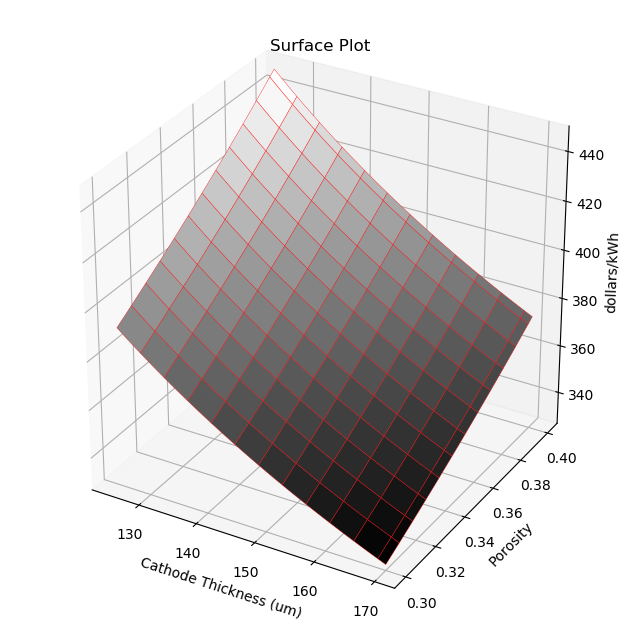

PyObject Text(0.5, 0.92, 'Surface Plot')

In [1]:
include("../src/PBCM.jl")

cell_general = cell_default()
cell_design_op = cylindrical_cell_designer(cell_general)
cost = cost_default()
cell_general,cost = convert_all(cell_general,cost,mult)

include("../unit_conversion_file.jl")

using PyPlot
using ForwardDiff

using3D()

cost.general_costs.no_units_mfg = converter(20.0, mult.units_mfg)
cost.cell_costs.cathode.AM[1]
n = 35

thic = range(125, stop=170, length=n)
poro = range(0.3, stop=0.4, length=n)

normalized_thic = range(0, 1, length = n)
normalized_poro = range(0, 1, length = n)


xgrid = repeat(thic', n, 1)
ygrid = repeat(poro, 1, n)

z = zeros(n,n)

z_grad_x = zeros(n,n)
z_grad_y = zeros(n,n)

legend_data = []


for i in 1:n, j in 1:n

    cell_general.cathode.por  = poro[j]
    cell_general.cathode.th   = converter(thic[i], mult.pos_th)


    dollars_kWh, MWh_per_year = cost_calc(cell_general, cost, system="Cell", cost_verbosity=0)
    z[j, i]                   = dollars_kWh

end


clf()
fig = figure("pyplot_surfaceplot",figsize=(8,8))
plot_surface(xgrid, ygrid, z, rstride=3,edgecolors="r", cstride=3, cmap=ColorMap("gray"), alpha=1, linewidth=0.25)
xlabel("Cathode Thickness (um)")
ylabel("Porosity")
zlabel("dollars/kWh")
title("Surface Plot")



In [ ]:
include("../src/PBCM.jl")

cell_general = cell_default()
cell_design_op = cylindrical_cell_designer(cell_general)
cost = cost_default()

include("../unit_conversion_file.jl")


using PyPlot

    ###################################################### USD/kWh vs MWH/year  #####################################################################

cost.cell_costs.cathode.AM[1] = 17.0
cell_general.cathode.por      = 0.25
cell_general.cathode.th       = converter([150.0, mult.pos_th[2], mult.pos_th[3]])
cell_general.design_verbosity = 0
cost_calc(cell_general, cost, system="Cell", cost_verbosity = 0)

param_x = []
param_y = []

for i in range(10, 200, length=100000)
    # cost.material.pos_AM[1] = i
    cost.general_costs.no_units_mfg = converter([i, mult.units_mfg[2], mult.units_mfg[3]])
    dollars_per_kWh, mfg_capacity = cost_calc(cell_general, cost, system="Cell", cost_verbosity=0)
    append!(param_y, dollars_per_kWh)
    append!(param_x, mfg_capacity)
end

# print(param_y)


clf()
plot(param_x, param_y)
xlabel(String("MWh/year"))
ylabel("Dollars per kWh")
title("Cost vs. MFG Capacity")
figure(2)


In [ ]:
include("../src/PBCM.jl")

cell_general = cell_default()
cell_design_op = cylindrical_cell_designer(cell_general)
cost = cost_default()

include("../unit_conversion_file.jl")



    ###################################################### USD/kWh vs Thickness Cathode  ######################################################

param_x = []
param_y = []

cost.cell_costs.cathode.AM[1]   = 17.0
cost.general_costs.no_units_mfg = converter([20.0, mult.units_mfg[2], mult.units_mfg[3]])
cell_general.cathode.por        = 0.3

for i in range(110, 170, length=100000)
    # cost.material.pos_AM[1] = i
    cell_general.cathode.th = converter([i, mult.pos_th[2], mult.pos_th[3]])
    dollars_per_kWh, mfg_capacity = cost_calc(cell_general, cost, system="Cell", cost_verbosity=0)
    append!(param_y, dollars_per_kWh)
    append!(param_x, i)
end

# print(param_y)

clf()
plot(param_x, param_y)
xlabel(String("Cathode thickness (microns)"))
ylabel("Dollars per kWh")
title("Cost vs. Cathode Thickness")
figure(2)
